In [1]:
# COMMON IMPORTS
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, InjectedState
from langchain.tools import tool
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.runnables import RunnableConfig

from pydantic import BaseModel, Field
from typing_extensions import Annotated, Optional

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_core.messages import ( HumanMessage, SystemMessage, AIMessage, ToolMessage, AnyMessage, RemoveMessage)
from langgraph.graph.message import add_messages
import os, subprocess, sys, contextlib, io, json, sqlite3
from codeact_db import select, insert_or_update, get_db_schema

DB_FILE = 'gdpr_sections.db'



load_dotenv()



/home/aidodo/Foundations_of_AgenticAI/agentic-labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

E0000 00:00:1767730625.560878    5841 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


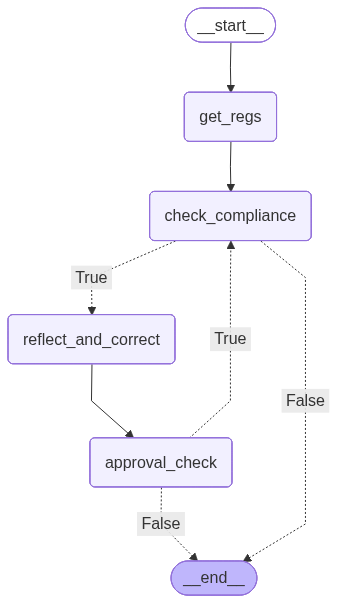

In [2]:
class ComplianceResult(BaseModel):
    conclusion: str = Field(description="A summary conclusion of the compliance check")
    result: str = Field(description="The result of the compliance check, either 'Compliant' or 'Non-Compliant' or 'Uncertain")
    email: str = Field(description="The email text that was checked for compliance.")


class ReflectionResponse(BaseModel):
    correction_email: str = Field(description="New improved email text to comply with GDPR, if applicable.")
    success: bool = Field(description="Indicates whether the previous action was successful.")

llm = ChatGoogleGenerativeAI(
    #model=os.getenv("GOOGLE_API_MODEL"),
    model="gemini-2.5-flash",
    temperature=0)



reflection_llm = ChatGroq(
    model=os.getenv('GROQ_API_MODEL'),
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

compliance_llm = llm.with_structured_output(ComplianceResult)






# STATE
class QueryState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]
    database_name: str

class GDPRState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]
    regs_loaded: bool = Field(default=False, description="Flag indicating if GDPR regulations have been loaded.")
    result: ComplianceResult = None
    email: str = None
    count: int = 0
    reflected_email: str = None
    approved: Optional[bool] = False

# TOOLS
@tool
def execute_code(code: str = Field(description="Code to be executed."),
                 state: Annotated[QueryState, InjectedState] = None
                 ) -> str:
    """
    Execute the Python code and returns the output or error message.
    You have access to a library for database access.  You have two functions:
    - select(query: str, parameters: Sequence[Any] | None = None)
    - insert_or_update(query: str, parameters: Sequence[Any] | None = None)
    You MUST set db_name argument to the variable 'database_name'.
    """
    """Run Python source in a fresh subprocess that inherits the current environment."""
    header = f"from codeact_db import select, insert_or_update\nimport os\nprint('ENVS:', os.environ)\n"
    code = header + "\n" + code
    envs = os.environ.copy()
    envs["DB_NAME"]=DB_FILE
    if not isinstance(code, str):
        raise TypeError("code must be a string")
    completed = subprocess.run(
        [sys.executable, "-c", code],
        capture_output=True,
        text=False,
        check=False,
        env=envs,
    )
    stdout = completed.stdout.decode("utf-8", errors="replace") if completed.stdout else ""
    stderr = completed.stderr.decode("utf-8", errors="replace") if completed.stderr else ""
    if completed.returncode != 0:
        detail = f"{stdout}{stderr}".strip()
        return f"Process exited with status {completed.returncode}." + (f"\n{detail}" if detail else "")
    return stdout if stdout else (stderr if stderr else "No output")



# NODES
def get_schema_node(state: QueryState) -> dict:
  
    schema = get_db_schema(state.database_name)
    message = AIMessage(content=f"<SCHEMA>:\n {json.dumps(schema)} \n</SCHEMA>\n")
    return {"messages": [message]}

    
def execute_code_node(state: QueryState) -> dict:
    
    result = llm.bind_tools(tools=[execute_code]).invoke(state.messages)
    return {"messages": result}

# SUBGRAPH
graph = StateGraph(QueryState)
graph.add_node("get_schema", get_schema_node)
graph.add_node("code", execute_code_node)
graph.add_node("execute", ToolNode(tools=[execute_code]))

graph.add_edge(START, "get_schema")
graph.add_edge("get_schema", "code")
graph.add_conditional_edges("code", lambda state: state.messages[-1].tool_calls == [],
                            path_map={True: END, False: "execute"})
graph.add_edge("execute", "code")

# compile graph
query_graph = graph.compile()
#query_graph

#MAIN GRAPH NODES
def get_regs(state: GDPRState) -> dict:
    if not state.regs_loaded:
        #invokde subgraph to load regs
        msgs = [SystemMessage(content="""
            You are an expert Python programmer and database analyst.
            You are a CodeAct agent for interacting with a database.
            You MUST use these functions to interact with the database:
                - select(query: str, parameters: Sequence[Any] | None = None)
                - insert_or_update(query: str, parameters: Sequence[Any] | None = None)
            Read the Schema provided to understand the database structure.
        """),
            HumanMessage(content="""Get all the sections""")]
        subgraph_state = QueryState(messages=msgs, database_name=DB_FILE)
        result = query_graph.invoke(subgraph_state)
        #state.messages.extend(result['messages'][-1].content)
        state.regs_loaded = True
        return {"messages": result['messages'][-1], "regs_loaded": state.regs_loaded}
    else:
        return {"messages": state.messages, "regs_loaded": state.regs_loaded}
    
def check_compliance(state: GDPRState) -> dict:
    
    #invoke to check compliance
    msgs = state.messages + [HumanMessage(content="Check if the following email contents is compliant, non-compliant  with GDPR or unknown : " + state.email)]
    print('Checking compliance...')
    result = compliance_llm.invoke(msgs)
    return {"result": result, "messages": state.messages, "regs_loaded": state.regs_loaded}

def reflect_and_correct(state: GDPRState) -> dict:
    # get last message and reflect on it against specific criteria
    last_message = state.result.result
    print('Reflecting on result:', last_message)
    reflection_prompt = f"""
    You are reflecting on the output of a GDPR compliance query agentic system.  The agent had the following email:
    <EMAIL>    
    {state.email}
    </EMAIL>

    The compliance response from the agent was:
    <RESPONSE>
    {last_message}
    </RESPONSE>


    If the response was non-compliant, provide a revised email that would help the email be GDPR compliant.
    """
    reflection_response = reflection_llm.with_structured_output(ReflectionResponse).invoke([HumanMessage(content=reflection_prompt)])
    instruction_message = '''Load the GDPR regulations from the database and check if the following email content is compliant, non-compliant  with GDPR or unknown: {email}'''
    #only remove state messages related to previous attempt not the AI system prompt
    new_messages = [RemoveMessage(id=m.id) for m in state.messages if not isinstance(m, SystemMessage)] + [HumanMessage(content=instruction_message.format(email=reflection_response.correction_email))]

    return {"messages": new_messages, "regs_loaded": state.regs_loaded, "reflected_email": reflection_response.correction_email, "count": state.count + 1}

def approval_check(state: GDPRState) -> dict:
    
    email = state.reflected_email 
    # Pause and ask for approval
    approved = interrupt(f"Do you approve this updated email ?\n {email} ")

    return {"approved": approved}


#MAIN GRAPH
main_graph = StateGraph(GDPRState)
main_graph.add_node("get_regs", get_regs)
main_graph.add_node("check_compliance", check_compliance)
main_graph.add_node("reflect_and_correct", reflect_and_correct)
main_graph.add_node("approval_check", approval_check)
main_graph.add_conditional_edges("check_compliance", 
    lambda state: state.result.result != "Compliant" and state.count < 10,
    path_map={True: "reflect_and_correct", False: END}
    )
main_graph.add_edge(START, "get_regs")
main_graph.add_edge("approval_check", "check_compliance")
main_graph.add_edge("get_regs", "check_compliance")
main_graph.add_edge("reflect_and_correct", "approval_check")
main_graph.add_conditional_edges("approval_check", 
    lambda state: state.approved,
    path_map={True: "check_compliance", False: END}
    )

saver = InMemorySaver()
# compile main graph
gdpr_graph = main_graph.compile(checkpointer=saver)
#gdpr_graph
gdpr_graph


In [15]:
# messages to invoke main graph
instruction_message = '''Load the GDPR regulations from the database and check if the following email content is compliant, non-compliant  with GDPR or unknown: {email}
'''
#Compliant email example
#email_content = '''Subject: Please confirm your subscription to the Daily Tech Newsletter

#Hello [Name],

#Thank you for signing up! We need to make sure we have the right email address. Please click the button below to confirm that you would like to receive our marketing updates.

#[Confirm Subscription]

#If you didn't request this, you can safely ignore this email. You won't be added to any lists unless you click the link above.'''

#Uncertain ?
#email_content = '''Subject: You left something behind!

#Hi [Name], we noticed you added a pair of running shoes to your cart but didn't finish your order. We've saved them for you for the next 24 hours.

#[Return to Cart]'''
# Non-Compliant email example
email_content = '''Subject: Reach 10x more customers today!

Hi [Name], I found your email address on a professional directory and thought you’d be interested in our lead generation software. We have helped dozens of companies in your industry.

When can we hop on a 15-minute call?'''
messages = [SystemMessage(content="You are an expert in GDPR compliance."), HumanMessage(content=instruction_message.format(email=email_content))]
# create config
config : RunnableConfig = {"configurable":{"thread_id":"Thread_1"}}
result = gdpr_graph.invoke(GDPRState(messages=messages, regs_loaded=False,email=email_content), config=config)

try:
    result['__interrupt__']
    #Approve the reflected email (HITL)
    result =gdpr_graph.invoke(Command(resume=True), config=config)
    print(f"FINAL RESULT ------> {result['result'].result}\n\n=================================\n\n")
    print(f"ORIGINAL EMAIL ------> {email_content}\n\n=================================\n\n")
    print(f"REFLECTED EMAIL ------> {result['reflected_email']}\n\n=================================\n\n")
    print(f"SUMMARY ------> :\n{result['result'].conclusion}")
except KeyError:
    print(f"FINAL RESULT ------> {result['result'].result}\n\n=================================\n\n")
    print(f"ORIGINAL EMAIL ------> {email_content}\n\n=================================\n\n")
    print(f"SUMMARY ------> :\n{result['result'].conclusion}")

Checking compliance...
Reflecting on result: Non-Compliant
Checking compliance...
Reflecting on result: Uncertain
FINAL RESULT ------> Uncertain



ORIGINAL EMAIL ------> Subject: Reach 10x more customers today!

Hi [Name], I found your email address on a professional directory and thought you’d be interested in our lead generation software. We have helped dozens of companies in your industry.

When can we hop on a 15-minute call?



REFLECTED EMAIL ------> Subject: Quick 15‑minute call about lead generation

Hi [Name],

I’m [Your Name] from [Company], a company that helps businesses in your industry grow their customer base. I found your contact on a public professional directory and would like to share a brief 15‑minute overview of our lead‑generation software.

If you’re interested, please let me know a convenient time. If you prefer not to receive further emails, simply reply with “STOP” or click the unsubscribe link below.

Best regards,
[Your Name]
[Your Title]
[Company]
[Phone]


In [19]:
#Compliant email example
email_content = '''Subject: Please confirm your subscription to the Daily Tech Newsletter

Hello [Name],

Thank you for signing up! We need to make sure we have the right email address. Please click the button below to confirm that you would like to receive our marketing updates.

[Confirm Subscription]

If you didn't request this, you can safely ignore this email. You won't be added to any lists unless you click the link above.'''

#Uncertain ?
email_content_1 = '''Subject: You left something behind!

Hi [Name], we noticed you added a pair of running shoes to your cart but didn't finish your order. We've saved them for you for the next 24 hours.

[Return to Cart]'''
# Non-Compliant email example
email_content_2 = '''Subject: Reach 10x more customers today!

Hi [Name], I found your email address on a professional directory and thought you’d be interested in our lead generation software. We have helped dozens of companies in your industry.

When can we hop on a 15-minute call?'''

In [20]:
instruction_message = '''Load the GDPR regulations from the database and check if the following email content is compliant, non-compliant  with GDPR or unknown: {email}
'''
emails = [email_content, email_content_1, email_content_2]
for email_content in emails:
    messages = [SystemMessage(content="You are an expert in GDPR compliance."), HumanMessage(content=instruction_message.format(email=email_content))]
    # create config
    config : RunnableConfig = {"configurable":{"thread_id":"Thread_1"}}
    result = gdpr_graph.invoke(GDPRState(messages=messages, regs_loaded=False,email=email_content), config=config)

    try:
        result['__interrupt__']
        #Approve the reflected email (HITL)
        result =gdpr_graph.invoke(Command(resume=True), config=config)
        print(f"FINAL RESULT ------> {result['result'].result}\n\n=================================\n\n")
        print(f"ORIGINAL EMAIL ------> {email_content}\n\n=================================\n\n")
        print(f"REFLECTED EMAIL ------> {result['reflected_email']}\n\n=================================\n\n")
        print(f"SUMMARY ------> :\n{result['result'].conclusion}")
    except KeyError:
        print(f"FINAL RESULT ------> {result['result'].result}\n\n=================================\n\n")
        print(f"ORIGINAL EMAIL ------> {email_content}\n\n=================================\n\n")
        print(f"SUMMARY ------> :\n{result['result'].conclusion}")
    except KeyError:
        print(f"FINAL RESULT ------> {result['result'].result}\n\n=================================\n\n")
        print(f"ORIGINAL EMAIL ------> {email_content}\n\n=================================\n\n")
        print(f"SUMMARY ------> :\n{result['result'].conclusion}")

Checking compliance...
FINAL RESULT ------> Compliant



ORIGINAL EMAIL ------> Subject: Please confirm your subscription to the Daily Tech Newsletter

Hello [Name],

Thank you for signing up! We need to make sure we have the right email address. Please click the button below to confirm that you would like to receive our marketing updates.

[Confirm Subscription]

If you didn't request this, you can safely ignore this email. You won't be added to any lists unless you click the link above.



SUMMARY ------> :
The email is a double opt-in confirmation, seeking explicit consent for marketing updates. It clearly states that inaction means no subscription, aligning with GDPR's requirements for freely given, specific, informed, and unambiguous consent, and the principle that silence or inactivity does not constitute consent.
Checking compliance...
Reflecting on result: Non-Compliant
Checking compliance...
FINAL RESULT ------> Compliant



ORIGINAL EMAIL ------> Subject: You left something b